# 【NB25】Adaptivity适配性分析

In [1]:
from Py01shared_code import AddPepperNoise, AddGaussianNoise, get_host_name_DINO_X, AddGaussianNoise_Pre_Snr, AddGaussianNoise_Pre, AddGaussianNoise_snr
from Py04Model_load import load_Pre_ViT_No1, get_args , dataset_from_geoTXT
from Py05_Matching_fun import idx2xy, xy2idx, idx_ex_range , dataset_from_geoTXT_aug_BiNorm, dataset_from_geoTXT_aug_BiNorm_BiAug, dataset_from_geoTXT_aug_BiNorm_BiAug_crop_and_padding, feature_normalize, minmaxscaler
from Py05_Matching_fun import dataset_from_geoTXT_aug_BiNorm_BiAug_Norm_first_then_mask, dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug, dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG, dataset_from_geoTXT_aug_BiNorm_BiAug_Pre_aug_noIMG_Resize
from Py06BiNet import load_Pre_BiNet_No1, get_global_norm, get_local_aug, load_Pre_BiNet_Res_NO1
from Py07EEnT import load_Pre_EEnT_tiny_No1
from Py08EEnT_NO2 import EEnT_NO2_tiny, load_Pre_EEnT_NO2_tiny
import Py10Bi_model
from Py11_Aug_self import MuskApply, MuskApply_tensor

In [2]:
import torch
import utils
import torch.distributed as dist
import matplotlib.pyplot as plt

from PIL import Image
from torchvision import transforms as pth_transforms
import numpy as np
import math

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import sys
import time

import random
import datetime

In [3]:
# 定义裁剪形状和步长
shape = (224, 224)
crop_shape = (224, 224)
# out_shape = (224, 224)
stride = 1
# mask_size = 224
pad_mode = "constant" # constant 为0填充、‘mean’——表示均值填充、‘median’——表示中位数
# map_grid_path = "./Matching_map_raw/太平洋1_grid.pth"

In [4]:
stride_test = 40 # 为使得每一个都填充到，stride_test应为：ex_range*2 + mask_size
ex_range = 10 
# ex_range = stride_test // 2 # 匹配用的先验范围
mask_size = 20
rand_test_num = 1000

In [5]:
# 若对应不上编码的Matching_fea文件，可在下方手动指定save_file_path
t_prefix = datetime.date.today().strftime('%Y%m%d')
# t_prefix = "20230625"
map_name = "印度洋1.txt" # 太平洋1.txt、test4.txt、极地5.txt、test5、印度洋1
# map_name = "大连海图数据.txt"
save_dir = "./Matching_fea/"
net_name = "【GRET_ELE_DB_NO2_bi】" + "_"
# mask_info = "mask_size" + str(mask_size) + "_"
mask_info = ""
addtion_info = "" +  "consPad" + "_"
host_name = get_host_name_DINO_X()

output_name = t_prefix + map_name[0:-4] + net_name + mask_info +  "fea_" + addtion_info + host_name + ".pth"# "-shape" # + str(shape[0]) + "stride" + str(stride) +  ".pth"
save_file_path = save_dir + output_name
load_grid = True # 是否读取划分好的网格节省时间
map_grid_path = "./Matching_map_raw/" + map_name[0:-4] + "_gridsize" + str(1) + ".pth"
print(save_file_path)

./Matching_fea/20231019印度洋1【GRET_ELE_DB_NO2_bi】_fea_consPad_DINO_3.pth


In [6]:
# save_file_path = "./Matching_fea/20230810test4grid_1【GRET_ELE_DB_NO2_bi】_tempfea_consPad_crop_shape_224DINO_3.pth"
# save_file_path = "./Matching_fea/20230811test5grid_1【GRET_ELE_DB_NO2_bi】_tempfea_consPad_crop_shape_224DINO_7.pth"
save_file_path = "./Matching_fea/20231019印度洋1grid_1【GRET_ELE_DB_NO2_bi】_tempfea_mask_size_20DINO_3.pth"
# save_file_path = "./Matching_fea/太平洋1_GRET_ELE_DB_NO2_bi_fea_mask20.pth"


args_self=[
# "--data_path","./Data_geo/Matching_test_high80/匹配test-high80",
# '--box_label_path',"./Data_geo/Matching_test_high80/【Label】匹配test-high80.csv",
# "--load_features","./dump_features", # 注释与否决定是否从文件加载特征
"--pretrained_weights", "./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth",
# "--pretrained_weights", "./checkpoint.pth",
# "--arch", "BiNet_NO1",
"--num_workers","4",
"--arch", "GRET_ELE_DB_NO2_bi", # 可选 BiNet_NO1、EEnT_tiny_NO1、EEnT_tiny_NO2, BiNet_Res_NO1, TBiNet_Res_NO2_bi
'--num_ele_slice', "20000",
]
thead_num = 10
args = get_args(args_self)


### 参数替换

* 如果从外部运行，且使用了其命名空间，可以通过检查某些变量是否存在来判断，是直接运行还是从外部运行

In [7]:
try:
    print("\r\n尝试读取外部变量：")
    print("pre_model_path_outside = " + str(pre_model_path_outside)) # 预训练权重
    # print("net_name_outside = " + str(net_name_outside)) # 网络名称
    print("arch_outside = " + str(arch_outside))
    print("save_file_path_outside = " + str(save_file_path_outside))
    print("map_grid_path_outside = " + str(map_grid_path_outside))
    print("map_name_outside = "+ str(map_name_outside))
    print("shape_outside = " + str(shape_outside))
    print("stride_test_outside = " + str(stride_test_outside))
    print("crop_shape_outside = " + str(crop_shape_outside))
    print("ex_range_outside = " + str(ex_range_outside))
    print("num_ele_slice_outside = ", num_ele_slice_outside)
except NameError: # 外部定义变量不存在，使用本地，do noting
    print("外部变量不存在，使用【本地变量】")
#     var_exists = False
else: # 外部变量存在，使用外部：替换
    print("外部变量存在，使用【外部配置】")
    args.pretrained_weights = pre_model_path_outside
    args.arch = arch_outside
    # net_name = net_name_outside
    save_file_path = save_file_path_outside
    map_grid_path = map_grid_path_outside
    map_name = map_name_outside
    shape = shape_outside
    stride_test = stride_test_outside
    crop_shape = crop_shape_outside
    ex_range = ex_range_outside
    mask_size = mask_size_outside
    pad_mode = pad_mode_outside
    args.num_ele_slice = num_ele_slice_outside
#     var_exists = True


尝试读取外部变量：
外部变量不存在，使用【本地变量】


### 载入网格

In [8]:
x,y,z = torch.load(map_grid_path)
print("已存储网格载入成功")
# 定义裁剪形状和步长
global_min = z.min()
global_max = z.max()



已存储网格载入成功


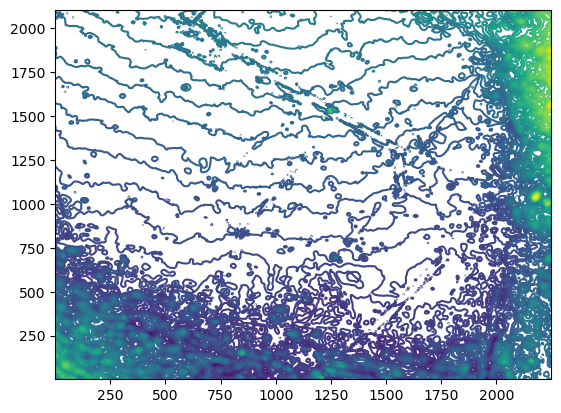

In [9]:
# 绘制等高线图
fig, ax = plt.subplots()
num_level = 50
level_li = np.linspace(z.min(), z.max(), num_level)
a = ax.contour(x, y, z, level_li) # 或者直接传入num_level，或传入一个等间隔的list

# ax.plot(x)
# 添加等高线标签
# ax.clabel(a, inline=True, fontsize=10)
# plt.savefig('./【NB25】适配性结果/' + map_name[0:-4] + "_levelnum_" + str(num_level) + '.tiff', dpi = 300)
# 显示图形
plt.show()

In [10]:
n_rows = (z.shape[0] - shape[0]) // stride + 1
n_cols = (z.shape[1] - shape[1]) // stride + 1
n_matrices = n_rows * n_cols
# n_rows + 112
print(str((n_rows, n_cols, n_matrices)))

(1884, 2025, 3815100)


In [11]:
per_li = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li.append(per_test)
per_li = np.percentile(z, np.linspace(0,100, args.num_ele_slice))
per_li = (per_li - global_min) / (global_max - global_min)
per_li[-1] = 1
print("已读取分位数列表：per_li， 份数" + str(args.num_ele_slice) )
# print(per_li)

已读取分位数列表：per_li， 份数20000


In [12]:
per_li_var = []
# for i in range(args.num_ele_slice):
#     per_test = np.percentile(z, 100 / args.num_ele_slice * (i + 1))
#     per_test = (per_test - global_min) / (global_max - global_min)
#     per_li_var.append(per_test)
per_li_var = np.percentile(z, np.linspace(0,100, args.num_ele_slice))
per_li_var = (per_li_var - global_min) / (global_max - global_min)
per_li_var[-1] = 1
print("已读取分位数列表：per_li_var， 份数" + str(args.num_ele_slice) )
# print(per_li)

已读取分位数列表：per_li_var， 份数20000


### 加载预存储的特征向量

In [13]:
%%time
fea_vec_li = torch.load(save_file_path)
print("【预存储特征加载完成】\n嵌入维度为 " + str(fea_vec_li.shape[1]) +  "\n向量个数为：" + str(fea_vec_li.shape[0]))

【预存储特征加载完成】
嵌入维度为 195
向量个数为：3815100
CPU times: user 2.35 s, sys: 3.33 s, total: 5.68 s
Wall time: 5.7 s


In [14]:
try:
    utils.init_distributed_mode(args)
except:
    print("已经启动，不再重复")
    pass

Will run the code on one GPU.
| distributed init (rank 0): env://


### 数据集加载

In [15]:
transform_for_match = pth_transforms.Compose([
    
#     AddGaussianNoise_snr(mean=0, variance=1, snr=( 1 - 0.04)),
#         AddGaussianNoise(mean=0, variance=1, amplitude=255),
    AddGaussianNoise(mean=0, variance=5, amplitude=1),
#     AddPepperNoise(snr = 0.999, p = 1.0),
#     pth_transforms.RandomRotation((0, 10), expand=False), # Rotation先，出来的图是正的
    MuskApply(mask_size = mask_size, mode = pad_mode), # constant为0填充、‘mean’——表示均值填充、‘median’——表示中位数
#     pth_transforms.RandomRotation((0, 10), expand=False), # Rotation后，出来的图是有斜角的
#     pth_transforms.Resize([224,224]),
    
    pth_transforms.ToTensor(),
    pth_transforms.Normalize(mean=[0.485], std=[0.229]),
])

transform_for_global_match = pth_transforms.Compose([
#     MuskApply(mask_size = mask_size, mode=pad_mode),
    pth_transforms.CenterCrop(mask_size),
    pth_transforms.ToTensor(),
])
dataset_geo = dataset_from_geoTXT_aug_BiNorm_BiAug(z, shape, stride, transform_for_match, transform_for_global_match, global_min, global_max)

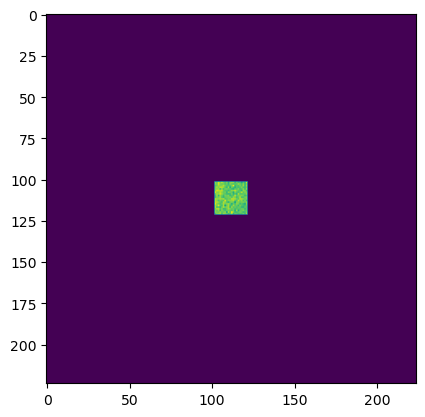

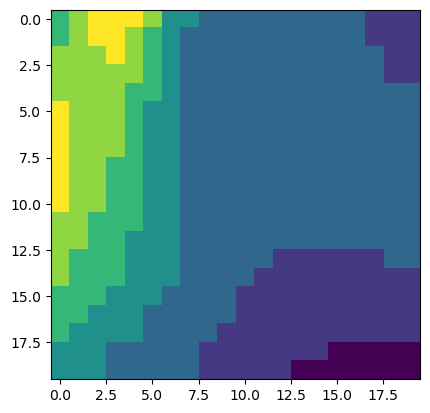

torch.Size([1, 224, 224])
torch.Size([1, 20, 20])
普通归一化与全局归一化图像


In [16]:
data,data_global_norm,_,_ = dataset_geo.__getitem__(1000)
plt.imshow(data.squeeze())
plt.show()
plt.imshow(data_global_norm.squeeze())
plt.show()
print(data.shape)
print(data_global_norm.shape)
print("普通归一化与全局归一化图像")

全局归一化图像


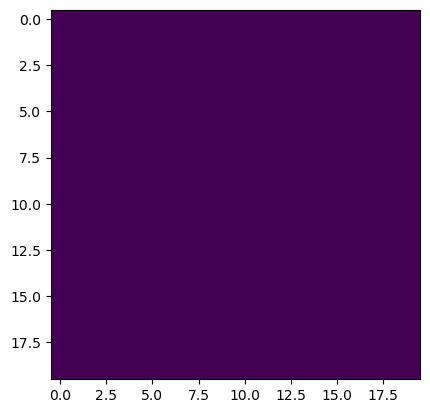

In [17]:
# 全局归一化
# def get_global_norm(data):
#     data_global_norm = (data - global_min) / (global_max - global_min)
#     # 给左上角与右下角赋值，便于观察最大最小（实际输入网络不需要这一步）
#     data_global_norm[0] = 0
#     data_global_norm[-1]  = 1
#     return data_global_norm

# 给左上角与右下角赋值，便于观察最大最小（实际输入网络不需要这一步）
data_global_norm[0] = 0
data_global_norm[-1]  = 1
plt.imshow(data_global_norm.squeeze())
print("全局归一化图像")

In [18]:
# 获取bof特征
load_bof_voc = True
if load_bof_voc:
    bof_voc, bof_stdSlr = torch.load("./bof_voc/voc_Pacific.pth")
    voc_k = bof_voc.shape[0]
    print("voc_k = ", voc_k, " (代表sift_bof特征维度为此值，后续的嵌入会沿用这一切分维度)")
    print("成功加载bof_voc")
else:
    voc_k = 100
    bof_voc, bof_stdSlr = get_bof_Pacific_voc(dataset_geo, using_num = 2000, voc_k = voc_k)
    torch.save((bof_voc, bof_stdSlr), "./bof_voc/voc_Pacific.pth")

voc_k =  100  (代表sift_bof特征维度为此值，后续的嵌入会沿用这一切分维度)
成功加载bof_voc


### 加载预训练模型

* 注意，这里加载的预训练模型需要与编码预存储的一致，例如使用【Try4】预训练模型

In [19]:
%%time
assert os.path.exists(args.pretrained_weights), "权重不存在，检查路径"

if args.arch == "BiNet_NO1":
    model = load_Pre_BiNet_No1(args)
elif args.arch == "EEnT_tiny_NO1": 
    model = load_Pre_EEnT_tiny_No1(args)
elif args.arch == "EEnT_tiny_NO2":
    model = load_Pre_EEnT_NO2_tiny(args, per_li = per_li)
    embed_dim = model.embed_dim
elif args.arch == "BiNet_Res_NO1":
    model = load_Pre_BiNet_Res_NO1(args)
    embed_dim = model.embed_dim
elif args.arch in Py10Bi_model.__dict__.keys():
    try:
        model = Py10Bi_model.__dict__[args.arch]() # 调用函数
        print("模型" + args.arch + "创建成功")
        Py10Bi_model.load_Pre_type1(model, args)
        print("预训练模型加载成功")
    except:
        model = Py10Bi_model.__dict__[args.arch](num_ele_slice=args.num_ele_slice, per_li=per_li, per_li_var=per_li_var,
                                           bof_voc=bof_voc, bof_stdSlr=bof_stdSlr, in_chans=1, voc_k = voc_k,
                                          g_min = global_min, g_max = global_max)
        embed_dim = model.embed_dim
        Py10Bi_model.load_Pre_type1(model, args)
        print("预训练模型加载成功")
else:
    assert 0, "不支持的模型"
    
# utils.init_distributed_mode(args)
print("【完成】使用预训练模型：" + str(args.pretrained_weights))
print("【完成】计算节点(process group)启动完成")

Take key teacher in provided checkpoint dict
Pretrained weights found at ./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth and loaded with msg: _IncompatibleKeys(missing_keys=[], unexpected_keys=['head.mlp.0.weight', 'head.mlp.0.bias', 'head.mlp.2.weight', 'head.mlp.2.bias', 'head.mlp.4.weight', 'head.mlp.4.bias', 'head.last_layer.weight_g', 'head.last_layer.weight_v'])
预训练模型加载成功
【完成】使用预训练模型：./【checkpoint存档】/20230728【GRET_ELE_DB_NO2_bi】DINO_7_01.pth
【完成】计算节点(process group)启动完成
CPU times: user 12.2 s, sys: 23.6 s, total: 35.9 s
Wall time: 3.57 s


### 单个点遍历匹配测试

In [20]:
def matching_iter(output_vec, search_range_li):
    pre_index = -1
    min_dis = 100000
    pdist = torch.nn.PairwiseDistance(p=2)
#     pdist = DINOLoss_for_Matching(out_dim = 192).cuda()

    for i in search_range_li:
        dis = pdist(output_vec, fea_vec_li[i, :].unsqueeze(0))
#         similarity = torch.cosine_similarity(output_vec.squeeze(), fea_vec_li[i, :], dim=0)
        if dis < min_dis:
            min_dis = dis
            pre_index = i
    return pre_index, min_dis

In [21]:
def distance_point(box1, box2):
    x_dis = math.pow((box1[0] - box2[0]), 2)
    y_dis = math.pow((box1[1] - box2[1]), 2)
    return math.sqrt(x_dis + y_dis)

In [22]:
# %%time
rand_idx = int(torch.rand([1], dtype=torch.float32) * len(dataset_geo))
# rand_idx = 5872663
print("测试序号:" + str(rand_idx))

data, data_global_norm, index, box =  dataset_geo.__getitem__(rand_idx)
# samples = samples.unsqueeze(0).cuda()
# data_global_norm = get_global_norm(samples)
# data = get_local_aug(samples)
data = data.unsqueeze(0).cuda(non_blocking=True)
data_global_norm = data_global_norm.unsqueeze(0).cuda(non_blocking=True)
output_vec = model(data, data_global_norm)
print("输出向量尺寸：" + str(output_vec.shape))

range_li = idx_ex_range(index, ex_range, n_rows, n_cols)
len(range_li)

pre_index, min_dis = matching_iter(output_vec, range_li)

# 计算像素偏差
center_Truth = idx2xy(index, n_rows, n_cols)
center_Pred  = idx2xy(pre_index, n_rows, n_cols)
grid_bias = distance_point(center_Truth, center_Pred)

print("匹配预测id为： " + str(pre_index))
print("真实标签id为： " + str(int(index)))
print("最小特征距离为：" + "{:.3f}".format(float(min_dis))) 
print("网格偏差距离：" + "{:.3f}".format(grid_bias))

测试序号:1183901
输出向量尺寸：torch.Size([1, 195])
匹配预测id为： 1183901
真实标签id为： 1183901
最小特征距离为：0.004
网格偏差距离：0.000


/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


## 适配性计算匹配

* 基于匹配程序【NB16】，将每轮遍历中的只匹配中心点，换为每一个点匹配，搜索范围不变。**统计准确率也是每个区块一统计**

In [23]:
from functools import partial
from multiprocessing.pool import Pool

In [24]:
shape = (224, 224)
# stride_test = 30 # 100, 30, 224
# ex_range = 50 # 先验范围

n_rows_test = (z.shape[0] - shape[0]) // stride_test + 1
n_cols_test = (z.shape[1] - shape[1]) // stride_test + 1
n_matrices_test = n_rows_test * n_cols_test
# n_rows + 112
print(str((n_rows_test, n_cols_test, n_matrices_test)))

(48, 51, 2448)


In [25]:
# assert 0

In [26]:
# 定义专属sampler
class MySampler_by_range(torch.utils.data.DistributedSampler ): # torch.utils.data.Sampler
    def __init__(self, dataset, shape, n_rows_test, n_cols_test, stride_test, ex_range):
        super(torch.utils.data.Sampler, self).__init__()
        self.dataset = dataset
        self.shape = shape
        self.ex_range = ex_range #	# 每一批数据量
        self.indices = range(len(dataset))	# 生成数据集的索引
#         self.count = int(len(dataset) / self.batch_size)	# 一共有多少批
        self.n_rows_test = n_rows_test
        self.n_cols_test = n_cols_test
        self.stride_test = stride_test
        self.point_per_area = (ex_range*2)**2
        self.count = n_rows_test * n_cols_test * self.point_per_area
        
        range_li_np = np.zeros(self.count)
        self.range_li = []
        for i in range(self.n_rows_test):
            for j in range(self.n_cols_test):
                num = i*self.n_cols_test + j
                start_i = i * self.stride_test
                start_j = j * self.stride_test
                # 计算中心点坐标
                center_i = start_i + self.shape[0] // 2
                center_j = start_j + self.shape[1] // 2
                # 转换为1步长的idx，便于检索
                idx_real = xy2idx(center_i, center_j, n_rows, n_cols) # 注意，这里的n_rows，n_cols是整张图的逐像素
                range_li_temp = idx_ex_range(idx_real, ex_range, n_rows, n_cols) 
#                 self.range_li = self.range_li + range_li_temp # 获取先验范围(当前的适配性分析子区域)
                range_li_np[num*self.point_per_area:(num+1)*self.point_per_area ] = range_li_temp # 预先分配内存会更快一些
                assert len(range_li_temp)==(ex_range*2)**2, "放入序号与range不匹配"
            print("[" + str(i)+ "/" + str(self.n_rows_test) + "]", end="\r")
#                 yield range_li # 为了多线程不能这么些
        self.range_li = range_li_np.astype(int).tolist()
#         print(self.range_li[2155000:2156000])
#         print(type(self.range_li))
        print(len(self.range_li))
#         print(self.range_li)
        print("按range计算数据集序号完成，batchsize应为：", self.point_per_area)
        
    def __iter__(self):
        return iter(self.range_li)
                
    def __len__(self):
        return self.count
sampler = MySampler_by_range(dataset_geo, shape, n_rows_test, n_cols_test, stride_test, ex_range)
data_loader_byRange = torch.utils.data.DataLoader(
    dataset_geo,
    sampler=sampler,
#     batch_size=args.batch_size_per_gpu,
    batch_size = (ex_range*2)**2, # 
    num_workers=args.num_workers,
#     num_workers = 10,
    pin_memory=True,
    drop_last=False,
)
# start = time.time()
# for k, (samples, samples_global_norm, index, box) in enumerate(data_loader_byRange):
#     if(k==100):
#         print(samples.shape)
#         break
# end = time.time()
# print(end-start, " s")

979200]
按range计算数据集序号完成，batchsize应为： 400


In [27]:
def print_result(file = sys.stdout):
    print("总时长: " + str(total_time) + " s", file = file)
    print("测试时的增强："+ str(transform_for_match), file = file)
    try:
        print(Gauss_aug_Obj, file = file)
    except:
        pass
    print("测试数量：" + str(n_rows_test) + "*" + str(n_cols_test) + " = " + str(n_matrices_test), file = file)
    print("crop_shape = " + str(crop_shape), file = file)
    print("步长stride_test  =" + str(stride_test), file = file)
    print("save_file_path = " + str(save_file_path), file = file)
    print("pretrained_weights = " + str(args.pretrained_weights), file = file)
    print("num_ele_slice = " + str(args.num_ele_slice), file = file)
    print("arch = " + str(args.arch), file = file)
    print("先验范围 = " + str(ex_range), file = file)
#     print("平均偏差 = " + "{:.5f}".format(avg_bias) + " grid", file = file)
    print("ACC_" + str(a) + " = " + "{:.2f}".format(acc_a*100) + "%", file = file)
    print("ACC_" + str(b) + " = " + "{:.2f}".format(acc_b*100) + "%", file = file)
    print("ACC_" + str(c) + " = " + "{:.2f}".format(acc_c*100) + "%", file = file)
#     print("特征平均距离" + "{:.2f}".format(float(avg_Fea_Distance)), file = file)
#     print("【ACC_li】从0-20 (step 0.5) 的偏差 " + str(Acc_li), file = file)

In [28]:
def write_to_temp(lines):
    with open('【临时】temp_log.txt', 'w') as f:
#         f = open('temp_log.txt', 'w')
        f.writelines(lines)
        f.close()

In [29]:
def match_single(output_vec, range_li, compute_li):
    Acc_li = Acc_li = [0] * ACC_range
    Bias_all = 0
    dis_fea_all = 0
    for ii,_ in enumerate(compute_li):
#         print(output_vec[ii].shape)
        pre_index, min_fea_dis = matching_iter(output_vec[ii], range_li)
        # 计算像素偏差
        center_Truth = idx2xy(index[ii], n_rows, n_cols)
        center_Pred  = idx2xy(pre_index, n_rows, n_cols)
        grid_bias = distance_point(center_Truth, center_Pred)
        # 计算特征偏差
        dis = pdist(output_vec[ii], fea_vec_li[index[ii], :].unsqueeze(0))
        for k in range(ACC_range):
            if grid_bias <= k / 2:
                Acc_li[k] += 1
        Bias_all += grid_bias
        dis_fea_all += dis
    return Acc_li, Bias_all, dis_fea_all

In [30]:
# assert 0

In [ ]:
# 

a = 1 # 距离小于1个的准确率
b = 3
c = 10
ACC_range = 41

fea_vec_li = fea_vec_li.cpu()

Acc_li = [0] * ACC_range
pdist = torch.nn.PairwiseDistance(p=2)
acc_subArea_array = torch.zeros(41, n_rows_test, n_cols_test)
bias_subArea_array = torch.zeros(1, n_rows_test, n_cols_test)
dis_fea_subArea_array = torch.zeros(1, n_rows_test, n_cols_test)
# t = tqdm(, ncols=80)
time_last = time.time()
start_time = time.time()
print("测试数量：" + str(n_rows_test) + "*" + str(n_cols_test) + " = " + str(n_matrices_test))
# for i in range(n_rows_test):
#     for j in range(n_cols_test):
for m, (samples, samples_global_norm, index, box) in enumerate(data_loader_byRange):
    i = m // n_cols_test
    j = m %  n_cols_test
    
#     break
    torch.cuda.empty_cache()
    interval = time.time() - time_last
    time_last = time.time()
    eta = interval * (n_cols_test * n_rows_test - i * n_cols_test - j)
    acc1_now = Acc_li[2] * 100 # / (i*n_cols_test + j + 1) * 100
    str_log = "Processcing num: [" + str(i*n_cols_test+j) +"/" + str(n_matrices_test) + "] "  + " Acc1_current_grid=" + "{:0.2f}".format(acc1_now) + "% eta:" + str(int(eta//60))+ ":" + "{:02d}".format(int(eta%60)) + "          "
    print(str_log, end = '\r')
    write_to_temp(["Running 【NB25】适配性分析匹配中……\n", str_log])


    start_i = i * stride_test
    start_j = j * stride_test
    # 计算中心点坐标
    center_i = start_i + shape[0] // 2
    center_j = start_j + shape[1] // 2
    # 转换为1步长的idx，便于检索
    idx_real = xy2idx(center_i, center_j, n_rows, n_cols)
    range_li = idx_ex_range(idx_real, ex_range, n_rows, n_cols) # 获取先验范围(当前的适配性分析子区域)
    # 匹配
    # matching_iter_for_adaptivity
    # 对待匹配区域编码
    samples = samples.cuda()
    samples_global_norm = samples_global_norm.cuda()
    with torch.no_grad():
        output_vec = model(samples, samples_global_norm)
        output_vec = output_vec.cpu()
    Acc_li = [0] * ACC_range
    Bias_all = 0
    dis_fea_all = 0

    # Calculates the number of subsets required for the quantity of cpus
    subset_size = int(np.ceil(len(range_li)/thead_num))
    # Divide the set into subsets according to the quantity of cpus
    range_li_part = [range_li[i:i + subset_size] for i in range(0, len(range_li), subset_size)]
    
    pool = Pool(processes=thead_num)
#     Acc_li, Bias_all, dis_fea_all = match_single(range_li ,output_vec, range_li)
    match_single_p = partial(match_single, output_vec, range_li) # 偏函数先传入俩参数
#     Acc_li, Bias_all, dis_fea_all = 
    thread_re_li = pool.map(match_single_p, range_li_part)
    pool.close()        # 关闭进程池，不再接受新的进程
    pool.join()         # 主进程阻塞等待子进程的退出
    
    # 汇总多线程计算结果
    Acc_li = [0] * ACC_range
    Bias_all = 0
    dis_fea_all = 0
    for thread_re in thread_re_li: # ACC_li Bias_all, dis_fea_all
        Acc_li = [i + j for i, j in zip(Acc_li, thread_re[0])]
        Bias_all += thread_re[1]
        dis_fea_all += thread_re[2]

    Acc_li = [acc / len(range_li) for acc in Acc_li] # 计算为频率
#     print(Acc_li)
    bias_subArea_array[0,i,j] = Bias_all / len(range_li)
    dis_fea_subArea_array[0,i,j] = dis_fea_all / len(range_li)
#         print(len(range_li)) # len(range_li)
    acc_subArea_array[:, i, j] = torch.tensor(Acc_li)
#         break
#     break
        
end_time = time.time()
total_time = end_time - start_time
print("\n处理完成")
# avg_bias = Bias_all / n_matrices_test
# avg_Fea_Distance = dis_fea_all / n_matrices_test
acc_subArea_array
acc_a = acc_subArea_array[a*2].mean()
acc_b = acc_subArea_array[b*2].mean()
acc_c = acc_subArea_array[c*2].mean()
print_result() # 默认参数打印到屏幕

log_file = open("【输出】NB25_adaptivity.txt", 'w')
print_result(file=log_file) # 重定向到文件
log_file.close()

测试数量：48*51 = 2448


In [ ]:
import os
# 尝试创建该地图的文件夹——地图名_网络名
try:
    folder_name =  map_name[0:-4] + "_" + args.arch
    os.makedirs("【NB25】适配性结果/"+ folder_name + "/") 
    print("创建成功：")
except:
    print("创建失败，已经存在", folder_name)
# 放入对应的文件夹
torch.save(acc_subArea_array, "./【NB25】适配性结果/" + folder_name + "/acc_subArea_array.pth")
np.savetxt("./【NB25】适配性结果/" + folder_name + "/acc_1_subArea_array.csv", acc_subArea_array[2], delimiter=',')
np.savetxt("./【NB25】适配性结果/" + folder_name + "/acc_3_subArea_array.csv", acc_subArea_array[6], delimiter=',')
np.savetxt("./【NB25】适配性结果/" + folder_name + "/grid_bias_subArea_array.csv", bias_subArea_array.squeeze(), delimiter=',')
np.savetxt("./【NB25】适配性结果/" + folder_name + "/dis_fea_subArea_array.csv", dis_fea_subArea_array.squeeze(), delimiter=',')

In [ ]:
# 画图
import torch
import matplotlib.pyplot as plt

# ax = plt.gca()

acc_subArea_array = torch.load("./【NB25】适配性结果/" + folder_name + "/acc_subArea_array.pth")
plt.imshow(acc_subArea_array[0])
# ax.invert_yaxis()  #y轴反向
plt.colorbar()
plt.savefig('./【NB25】适配性结果/' + folder_name + '/acc_subArea_array_acc00.tiff', dpi = 300)
plt.show()

# acc_subArea_array = torch.load("./【NB25】适配性结果/acc_subArea_array.pth")
plt.imshow(acc_subArea_array[2])
plt.colorbar()
plt.savefig('./【NB25】适配性结果/' + folder_name + '/acc_subArea_array_acc01.tiff', dpi = 300)
plt.show()

# acc_subArea_array = torch.load("./【NB25】适配性结果/acc_subArea_array.pth")
plt.imshow(acc_subArea_array[6])
plt.colorbar()
plt.savefig('./【NB25】适配性结果/' + folder_name + '/acc_subArea_array_acc03.tiff', dpi = 300)
plt.show()

# acc_subArea_array = torch.load("./【NB25】适配性结果/acc_subArea_array.pth")
plt.imshow(acc_subArea_array[10])
plt.colorbar()
plt.savefig('./【NB25】适配性结果/' + folder_name + '/acc_subArea_array_acc05.tiff', dpi = 300)
plt.show()

# acc_subArea_array = torch.load("./【NB25】适配性结果/acc_subArea_array.pth")
plt.imshow(acc_subArea_array[20])
plt.colorbar()
plt.savefig('./【NB25】适配性结果/' + folder_name + '/acc_subArea_array_acc10.tiff', dpi = 300)
plt.show()

## 训练分类头

* 训练一个输入是区域中心点的图像，输出是其在ACC3、或其他准确率下的匹配概率

In [ ]:
import torch
import matplotlib.pyplot as plt
ACC_select = 0 # 指定要拟合的acc
folder_name =  map_name[0:-4] + "_" + args.arch
acc_subArea_array = torch.load("./【NB25】适配性结果/" + folder_name + "/acc_subArea_array.pth")

* 加载**数据集**

In [ ]:
# 数据（使用不加噪声的方案，直接读取fea_li）.标签，标签即为ACC准确率
class fea_dataset(): # 定义由特征向量列表来的dataset
    def __init__(self, fea_li, Acc_li, n_rows_test, n_cols_test, stride_test, shape, label_acc_num):
        self.fea_li = fea_li
        self.Acc_li = Acc_li
        self.n_rows_test = n_rows_test
        self.n_cols_test = n_cols_test
        self.stride_test = stride_test
        self.shape = shape
        self.label_acc_num = label_acc_num
        
    def __getitem__(self, idx):
        # 找到fea_li序号
        i = idx // self.n_cols_test
        j = idx %  self.n_cols_test
        # 计算中心点坐标
        start_i = i * stride_test
        start_j = j * stride_test
        center_i = start_i + self.shape[0] // 2
        center_j = start_j + self.shape[1] // 2
        # 转换为1步长的idx，便于检索
        idx_real = xy2idx(center_i, center_j, n_rows, n_cols) # n_rows是全局的
        fea_data = self.fea_li[idx_real]
        
        # 找到“label”：从Acc_li中来
        acc = self.Acc_li[self.label_acc_num * 2, i, j]
        return fea_data, acc
        
    def __len__(self):
        return self.n_rows_test*self.n_cols_test

dataset_fea = fea_dataset(fea_vec_li.cpu(), acc_subArea_array, n_rows_test, n_cols_test, stride_test, shape, ACC_select)

# dataloader
data_loader_fea = torch.utils.data.DataLoader(
    dataset_fea,
#     sampler=sampler,
    batch_size=200,
    num_workers=args.num_workers,
#     num_workers = 10,
    pin_memory=True,
    drop_last=False,
    shuffle=True,
)

In [ ]:
# for i, (fea_data, acc) in enumerate(data_loader_fea):
#     pass

* 定义网络结构、损失函数、lr、优化器

In [ ]:
# 网络结构
#需要继承nn.Module，不要忘了
class NN(nn.Module):
    def __init__(self):
    	#super(NN,self).__init__()如果不理解就背下来，不懂python的super可以百度一下
        super(NN,self).__init__()
        #self.fc1构建第一个全连接层（full connect），nn.Linear是torch的全连接层方法，两个参数是左右的神经元个数
        data_dim = fea_vec_li.shape[1]
        self.fc1 = nn.Linear(data_dim, 32)
        self.fc2 = nn.Linear(32,1)
        
    def forward(self,x):
        x = self.fc1(x)
        #F.relu是torch的relu激活函数，还有其他激活函数，可以参考官网
        x = F.relu(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x
net_NN = NN()
net_NN = net_NN.cuda()

In [ ]:
#损失函数，也可以选择其他损失函数
# criterion = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
#学习率
lr = 0.005
#优化方法，也可以选择其他优化方法
#net_NN.parameters(),将实例的参数传递给优化函数，优化函数自动计算导数
optimizer = torch.optim.Adam(net_NN.parameters(),lr = lr)

* 开始训练与结果保存

In [ ]:
# 训练
def train(model, criterion, optimizer, epochs):
    loss = 0.0
    for epoch in range(epochs):
        for i, (fea_data, acc) in enumerate(data_loader_fea):
#             (inputs, labels) =  data
            #step1，获取inputs，计算outputs
            #因为是全连接网络，所以需要reshape到一维，卷积不需要
            fea_data = fea_data.cuda()
            acc = acc.unsqueeze(1).cuda()
            outputs = model(fea_data)

            #step2，清零梯度，计算loss，反向传播
            optimizer.zero_grad()
            loss = criterion(outputs, acc)
            loss.backward()
            optimizer.step()
            
            if i%10 == 0:
                print('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, epochs, loss.item()), end="\r") 


In [ ]:
train(net_NN, criterion, optimizer, 100)

In [ ]:
torch.save(net_NN,'./【NB25】适配性结果/' + folder_name + '/FCNet01.pkl')

* 可视化

In [ ]:
net = torch.load('./【NB25】适配性结果/' + folder_name + '/FCNet01.pkl')

In [ ]:
net.cuda().eval()
acc_array_pre = torch.zeros(n_rows_test, n_cols_test)
acc_array_GT  = torch.zeros(n_rows_test, n_cols_test)
# for m, (fea_data, acc) in enumerate(data_loader_fea):
for m in range(n_rows_test*n_cols_test):
    fea_data, acc = dataset_fea.__getitem__(m)
    fea_data = fea_data.cuda()
    acc = acc.cuda()
    with torch.no_grad():
        outputs = net(fea_data)
    i = m // n_cols_test
    j = m %  n_cols_test
    acc_array_pre[i,j] = outputs
    acc_array_GT[i,j]  = acc

In [ ]:
plt.imshow(acc_array_GT)
plt.ylim(0, acc_array_GT.shape[0]-1)
torch.save(acc_array_GT,'./【NB25】适配性结果/' + folder_name + '/acc_array_GT.pth')
plt.savefig('./【NB25】适配性结果/' + folder_name + '/acc_array_GT.tiff', dpi = 300)
plt.colorbar()
plt.show()
plt.imshow(acc_array_pre)
plt.ylim(0, acc_array_pre.shape[0]-1)
torch.save(acc_array_pre,'./【NB25】适配性结果/' + folder_name + '/acc_array_pre.pth')
plt.savefig('./【NB25】适配性结果/' + folder_name + '/acc_array_pre.tiff', dpi = 300)
plt.colorbar()
plt.show()

In [ ]:
# 尝试绘制相似度图
simi_mat = torch.zeros_like(acc_array_GT)
select_core = (10,12)
fea_data_core, acc = dataset_fea.__getitem__(select_core[0] * n_cols_test + select_core[1])
for i in range(n_rows_test):
    for j in range(n_cols_test):
        fea_data, acc = dataset_fea.__getitem__(i*n_cols_test+j)
        simi = torch.cosine_similarity(fea_data_core, fea_data,dim=0)
        simi_mat[i,j] = simi
plt.imshow(simi_mat)
print(simi_mat.mean())
plt.colorbar()

In [ ]:
acc_array_pre.max()

# 交叉泛化实验

In [ ]:
# 网络加载
# head_folder = "太平洋1_GRET_ELE_DB_NO2_bi"
head_folder = folder_name # 使用自己训练的分类头
net =  torch.load('./【NB25】适配性结果/' + head_folder + '/FCNet01.pkl')

In [ ]:
net.cuda().eval()
acc_array_pre = torch.zeros(n_rows_test, n_cols_test)
acc_array_GT  = torch.zeros(n_rows_test, n_cols_test)
# for m, (fea_data, acc) in enumerate(data_loader_fea):
# 实施推理，并与GT对比
for m in range(n_rows_test*n_cols_test):
    fea_data, acc = dataset_fea.__getitem__(m)
    fea_data = fea_data.cuda()
    acc = acc.cuda()
    with torch.no_grad():
        outputs = net(fea_data)
    i = m // n_cols_test
    j = m %  n_cols_test
    acc_array_pre[i,j] = outputs
    acc_array_GT[i,j]  = acc

In [ ]:
plt.imshow(acc_array_GT)
plt.show()
plt.imshow(acc_array_pre)
plt.show()

In [ ]:
!shutdown -h now